# Trying Deep Learning models for MRI-based Water-fat separation
In this notebook, you can upload your own Chemical Shift-Encoded (CSE)-MR images and obtain the separated water-fat signals using the different DL-based models developed in this project. All of them were developed to work only with CSE-MR images obtained at **1.5T** scanners.

The accepted data formats to upload your data are:
* DICOM files
* MAT files - using the [ISMRM Water-Fat Toolbox](https://www.ismrm.org/workshops/FatWater12/data.htm) format

The available DL models for testing are:
* U-Net
* Multi-Decoder Water-Fat separation Network (MDWF-Net) - Refer to [DOI:10.1007/s00330-023-09576-2](https://doi.org/10.1007/s00330-023-09576-2)
* Variable Echo Times neural Network (VET-Net) - Refer to [DOI:10.1007/s00330-024-11164-x](https://doi.org/10.1007/s00330-024-11164-x)
* Artificial Intelligence-based Decomposition of water and fat with Echo asymmetry and Least squares estimation (AI-DEAL) - Soon to be published!

## Importing libraries

In [1]:
import os
import json
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut
import nibabel as nib

import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets

from itertools import cycle
from time import process_time

Optionally, you can disable any available GPU. This is useful if your GPU's size is not enough to handle the data arrays.

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

Finally, we the customized libraries included in this repository are imported.

In [3]:
import tf2lib as tl
import DLlib as dl
import pylib as py
import wflib as wf
import data

## Loading CSE-MRI data
First, the dataset directory must be specified

In [4]:
# Dataset directory - Read DICOM files
# file_dir = "C:/Users/jpmen/OneDrive - Universidad Católica de Chile/Documents/MRI-Datasets/Anon_INTA/016/2D_NSA1_24S_2MM_IM_0007_anon/2D_NSA1_24S_2MM_IM_0007_anon.mat"
# file_dir = "C:/Users/jpmen/OneDrive - Universidad Católica de Chile\Documents\MRI-Datasets\PDFF_Phantom_Data\datasets\site6_1p5T_protocol2.mat"
# file_dir = "C:/Users/jpmen/Documents/AI-PDFF/data/BVH014/MR_20180420/nifti_output"

# Future output variables
F = list() # PDFF 
P = list() # FM 
R = list() # WF 
R2= list() # R2 

# Future uncertainty variables (AI-DEAL only)
PDFF_vars = list()
WF_vars = list()
R2_vars = list()
FM_vars = list()

i = 0
fm_sc = 300.0
r2_sc = 200.0

In the following block, you can choose the data format to be loaded. The default option is MAT files.

It should be noted that the array shape within DICOM files can vary according to the scanner in which MR data was acquired.

In [5]:
data_sel = widgets.Dropdown(
    options=['MAT','DICOM','NIFTI','QSM'],
    value='MAT',
    description='Data format:',
    disabled=False,
)
data_sel

Dropdown(description='Data format:', options=('MAT', 'DICOM', 'NIFTI', 'QSM'), value='MAT')

In [6]:
if data_sel.value == 'DICOM':
    images = []
    te_list = []
    err_flag = False
    dicom_files = sorted([os.path.join(file_dir, f) for f in os.listdir(file_dir)
                          if f.endswith(".dcm")])
    for j, f in enumerate(dicom_files):
        ds = pydicom.dcmread(f)
        img = ds.pixel_array.astype(np.float32)

        img_comp = str(ds.get((0x2005, 0x1011), pydicom.DataElement((0x2005, 0x1011), 'DS', 1)).value)
        echo_time = float(ds.get((0x0018, 0x0081), pydicom.DataElement((0x0018, 0x0081), 'DS', 1)).value)
        echo_num = int(ds.get((0x0018, 0x0086), pydicom.DataElement((0x0018, 0x0086), 'DS', 1)).value)
        echo_all = int(ds.get((0x0018, 0x0091), pydicom.DataElement((0x0018, 0x0091), 'DS', 1)).value)
        RescaleIntercept = float(ds.get((0x2005, 0x100D), pydicom.DataElement((0x2005, 0x100D), 'DS', 1)).value)
        RescaleSlope = float(ds.get((0x2005, 0x100A), pydicom.DataElement((0x2005, 0x100A), 'DS', 1)).value)

        resc_img = RescaleSlope*(img-RescaleIntercept)

        if img_comp == "R" and echo_num == 1:
            err_flag = False
            echoes = list()
            t_echoes = list()

        if img_comp == "R":
            aux_img = np.expand_dims(resc_img,axis=-1)
        elif img_comp == "I":
            aux_img = np.concatenate([aux_img,np.expand_dims(resc_img,axis=-1)], axis=-1)
            if aux_img.shape[-1] == 2:
                echoes.append(aux_img)
                t_echoes.append(echo_time)
            else:
                print(f,echo_num,len(images))
                err_flag = True

            if echo_all == len(echoes) and (not err_flag):
                im_echoes = np.stack(echoes, axis=0)
                # Normalization considering max magnitude value
                mag_echoes = np.sqrt(np.sum(np.square(im_echoes),axis=-1,keepdims=True))
                im_echoes_norm = im_echoes/np.max(mag_echoes)
                # Masking considering magnitude threshold
                im_echoes_mean = np.mean(mag_echoes/np.max(mag_echoes),axis=0,keepdims=True)
                im_echoes_mask = np.repeat(im_echoes_mean>0.05,echo_all,axis=0)
                im_echoes_mask = np.repeat(im_echoes_mask,2,axis=-1)
                images.append(np.where(im_echoes_mask,im_echoes_norm,0.0))
                # Process echo times
                t_echoes_np = np.array(t_echoes) * 1e-3
                te_list.append(t_echoes_np)
    
    X = np.stack(images, axis=0)  # (num_echoes, H, W, 2)
    TE = np.stack(te_list, axis=0)
elif data_sel.value == 'NIFTI':
    dicom_files = sorted([os.path.join(file_dir, f) for f in os.listdir(file_dir)
                          if f.endswith(".nii.gz")])
    avoid_comps = ['imaginary','real','Eq']
    dicom_files = sorted([f for f in dicom_files if not any(char in f for char in avoid_comps)])
    # print(dicom_files)

    nifti_file = dicom_files[0]
    fn_noEch = nifti_file.split("_e")[0]

    # Load NIfTI image
    img = nib.load(nifti_file)
    data = img.get_fdata(dtype=np.float32)  # shape: (X, Y, Z, echoes?) or (X, Y, Z)
    
    # Load JSON sidecar (contains echo times, etc.)
    json_file = nifti_file.replace(".nii.gz", ".json")
    metadata = {}
    if os.path.exists(json_file):
        with open(json_file, "r") as f:
            metadata = json.load(f)

    # Define useful parameters
    ne = metadata["EchoTrainLength"]

    # Generate multi-echo volume to be filled
    V_shape = list(data.shape)
    V_shape.insert(2, ne)
    V = np.zeros(V_shape+[2], dtype=np.float32)
    TE = np.zeros((V_shape[-1],ne), dtype=np.float32)
    V_mag_all = np.zeros(V_shape, dtype=np.float32)

    for ech in range(ne):
        # Magnitude file processing
        nifti_file_mag = fn_noEch + '_e' + str(ech+1) + '.nii.gz'
        img_mag = nib.load(nifti_file_mag)
        V_mag = img_mag.get_fdata(dtype=np.float32)

        json_file_mag = nifti_file_mag.replace(".nii.gz", ".json")
        metadata_mag = {}
        if os.path.exists(json_file_mag):
            with open(json_file_mag, "r") as f:
                metadata_mag = json.load(f)

        V_mag_resc = np.array(V_mag) # / float(metadata_mag["PhilipsScaleSlope"]);
        if ech == 0:
            V_sc = np.max(V_mag_resc)

        # Phase file processing
        nifti_file_ph = fn_noEch + '_e' + str(ech+1) + '_ph.nii.gz'
        img_ph = nib.load(nifti_file_ph)
        V_ph = img_ph.get_fdata(dtype=np.float32)

        json_file_ph = nifti_file_ph.replace(".nii.gz", ".json")
        metadata_ph = {}
        if os.path.exists(json_file_ph):
            with open(json_file_ph, "r") as f:
                metadata_ph = json.load(f)

        V_ph_resc = np.array(V_ph) # / float(metadata_ph["PhilipsScaleSlope"]);

        # Combining into complex volume
        if V_mag_resc.shape[2] == V_ph_resc.shape[2]:
            V_ech = V_mag_resc * np.exp(1j*V_ph_resc) / V_sc;
        else:
            V_ech = np.zeros([V.shape[0],V.shape[1],V.shape[3]]);
            print('\tMismatch between mag and phase at echo:',str(ech))

        if V.shape[3] == V_ech.shape[2]:
            V[:,:,ech,:,0] = np.real(V_ech);
            V[:,:,ech,:,1] = np.imag(V_ech);
            TE[:,ech] = float(metadata_mag["EchoTime"]);
            V_mag_all[:,:,ech,:] = np.abs(V_ech)
        else:
            print('\tMismatch between complex array and 1st echo at echo',str(ech))

    # Get mask from the mean of all-echoes magnitudes
    V_mag_mean = np.mean(V_mag_all,axis=2,keepdims=True)
    V_mag_mean = np.expand_dims(np.repeat(V_mag_mean,ne,axis=2),axis=-1)
    V_mag_mean = np.repeat(V_mag_mean,2,axis=-1)
    V = np.where(V_mag_mean >= 0.05, V, 0.0)
    
    # Rearrange to obtain the required dimensionality
    X = np.transpose(V, axes=[3,2,1,0,4]) # (num_slices, num_echoes, H, W, 2)
    X = np.flip(X,axis=2)
    TE = np.array(TE)
elif data_sel.value == 'MAT':
    mat = sio.loadmat(file_dir)
    if 'imDataParams' in mat.keys():
        acq = mat['imDataParams'][0,0][0].astype('complex64')
        TE = mat['imDataParams'][0,0][1].astype('float32')
    elif 'imDataAll' in  mat.keys():
        acq = mat['imDataAll'][0,0][4].astype('complex64')
        TE = mat['imDataAll'][0,0][0].astype('float32') #0/2
    if acq.shape[0] % 16 != 0.0:
        acq = acq[:(acq.shape[0]-acq.shape[0]%16)]
    acq = np.transpose(acq, (2,4,0,1,3)) / np.max(np.abs(acq))
    acq_real = np.real(acq)
    acq_imag = np.imag(acq)
    X = np.concatenate((acq_real,acq_imag),axis=-1)
    X = np.flip(X,axis=0)
elif data_sel.value == 'QSM':
    mat = sio.loadmat(file_dir)
    acq = mat['S'].astype('complex64')
    TE = mat['TE'].astype('float32')
    TE *= 1e-3
    if acq.shape[0] % 16 != 0.0:
        acq = acq[:(acq.shape[0]-acq.shape[0]%16)]
    acq = np.transpose(acq, (2,3,0,1))
    acq_real = np.real(np.expand_dims(acq,axis=-1))
    acq_imag = np.imag(np.expand_dims(acq,axis=-1))
    X = np.concatenate((acq_real,acq_imag),axis=-1)
    #X = X[::3,...]
TE = np.expand_dims(TE,axis=-1)

In [7]:
# X = X[:,::2,...]
# TE = TE[:,::2,...]

In [8]:
# Build tensorflow dataset
if data_sel.value == 'DICOM' or data_sel.value == 'NIFTI':
    TE = tf.cast(TE, tf.float32)
else:
    TE = tf.repeat(TE, [X.shape[0]], axis=0)
A_dataset = tf.data.Dataset.from_tensor_slices((X,TE))
test_iter = cycle(A_dataset)

In [9]:
TE.shape

TensorShape([24, 6, 1])

## Model Selection

In [10]:
model_sel = widgets.Dropdown(
    options=['U-Net','MDWF-Net','2D-Net','VET-Net','AI-DEAL','Single'],
    value='AI-DEAL',
    description='Model:',
    disabled=False,
)
model_sel

Dropdown(description='Model:', index=4, options=('U-Net', 'MDWF-Net', '2D-Net', 'VET-Net', 'AI-DEAL', 'Single'…

The original training dataset had CSE-MRI data from 149 subjects. However, all the models have different versions that were trained using different ratios of real and synthetic data. In the following menu, you can choose the version that you want to use depending on the number of subjects whose (real) data that was used for training.

* *Disclaimer:* In the cases of U-Net and MDWF-Net, this option is only valid for 6-echo models; there is only a single 3-echo version for each of them and they were trained using real data only.

In [11]:
data_ratio_sel = widgets.Dropdown(
    options=[0,3,9,15,149],
    value=149,
    description='Real subjects considered for training:',
    disabled=False,
)
data_ratio_sel

Dropdown(description='Real subjects considered for training:', index=4, options=(0, 3, 9, 15, 149), value=149)

Additionally, you can also set the number of echoes to be considered as input. This parameter will change the imported version of U-Net and MDWF-Net models, while the remaining models will not depend on this value as they are able to handle different echo train lengths.

In [12]:
ech_sel = widgets.IntSlider(
    value=6,
    min=2,
    max=12,
    step=1,
    description='Num. Echoes:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
ech_sel

IntSlider(value=6, continuous_update=False, description='Num. Echoes:', max=12, min=2)

For those models that use least squares to calculate water-fat signals after demodulating the CSE-MR signal (VET-Net & AI-DEAL), you can also choose to discard the first echo, since it has been demonstrated that its phase is usually corrupted (see [Hernando et al. (2012), *Addressing phase errors in fat‐water imaging using a mixed magnitude/complex fitting method*](https://onlinelibrary.wiley.com/doi/abs/10.1002/mrm.23044)).

In [13]:
remove_ech1 = widgets.Checkbox(
    value=False,
    description='Remove first echo',
)
remove_ech1

Checkbox(value=False, description='Remove first echo')

Optionally, you can also enable the resoultion of the water-fat separation using a phase-constrained least squares approach. By doing this, you are ensuring that the phase of the water-only and the fat-only signals are the same.

In [14]:
phase_const = widgets.Checkbox(
    value=False,
    description='Phase-constrained LS',
)
phase_const

Checkbox(value=False, description='Phase-constrained LS')

Finally, you have to specify the way in which PDFF is going to be calculated:
1) Magnitude-based: $$PDFF = \frac{|\rho_F|}{|\rho_W|+|\rho_F|}$$
2) Using magnitude discrimination: $$PDFF = \begin{cases} \frac{|\rho_F|}{|\rho_W+\rho_F|} & ,~if~~|\rho_F|>|\rho_W| \\ 1-\frac{|\rho_W|}{|\rho_W+\rho_F|} & ,~else \end{cases}$$

If you choose the **phase-constrained solution, both PDFF definitions will be equal**.

In [15]:
pdff_def = widgets.Dropdown(
    options=['Magnitude-based','Magnitude-discrimination'],
    value='Magnitude-based',
    description='PDFF definition',
    disabled=False,
)
pdff_def

Dropdown(description='PDFF definition', options=('Magnitude-based', 'Magnitude-discrimination'), value='Magnit…

_Experimental:_ There is an ongoing development of a VET-Net model for 3T CSE-MRI. You can enable the 3T model by clicking the box below

In [16]:
enable_3p0 = widgets.Checkbox(
    value=False,
    description='3T Model',
)
enable_3p0

Checkbox(value=False, description='3T Model')

## Building the model's architecture and loading the weights

In [17]:
if model_sel.value == 'U-Net':
    if ech_sel.value == 6:
        if data_ratio_sel.value == 149:
            model_fn = 'Sup-202'
        elif data_ratio_sel.value == 15:
            model_fn = 'Sup-403'
        elif data_ratio_sel.value == 9:
            model_fn = 'Sup-402'
        elif data_ratio_sel.value == 3:
            model_fn = 'Sup-401'
        elif data_ratio_sel.value == 0:
            model_fn = 'Sup-400'
    elif ech_sel.value == 3:
        model_fn = 'Sup-203'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.UNet(input_shape=(None,None,2*ech_sel.value), n_out=2, filters=args.n_G_filters,output_activation='relu')
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'MDWF-Net':
    if ech_sel.value == 6:
        if data_ratio_sel.value == 149:
            model_fn = 'Sup-204'
        elif data_ratio_sel.value == 15:
            model_fn = 'Sup-404'
        elif data_ratio_sel.value == 9:
            model_fn = 'Sup-405'
        elif data_ratio_sel.value == 3:
            model_fn = 'Sup-406'
        elif data_ratio_sel.value == 0:
            model_fn = 'Sup-407'
    elif ech_sel.value == 3:
        model_fn = 'Sup-205'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.MDWF_Generator(input_shape=(None,None,2*ech_sel.value), filters=args.n_G_filters, 
                              WF_self_attention=args.D1_SelfAttention, R2_self_attention=args.D2_SelfAttention,
                              FM_self_attention=args.D3_SelfAttention)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == '2D-Net':
    model_fn = 'Sup-200'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.PM_Generator(input_shape=(None,None,2*ech_sel.value), te_input=False, ME_layer=None, filters=args.n_G_filters)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'VET-Net':
    if enable_3p0.value:
        model_fn = 'TEaug-301'
    else:
        if data_ratio_sel.value == 149:
            model_fn = 'TEaug-300'
        elif data_ratio_sel.value == 15:
            model_fn = 'TEaug-311'
        elif data_ratio_sel.value == 9:
            model_fn = 'TEaug-310'
        elif data_ratio_sel.value == 3:
            model_fn = 'TEaug-309'
        elif data_ratio_sel.value == 0:
            model_fn = 'TEaug-308'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.PM_Generator(input_shape=(None,None,None,2), te_input=True, te_shape=(None,), filters=args.n_G_filters)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'AI-DEAL':
    experiment_dir = py.join('output','Unsup-306')
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.UNet(input_shape=(None,None,None,2), bayesian=True, ME_layer=True, filters=args.n_G_filters,
                    self_attention=args.D1_SelfAttention)
    G_A2R2= dl.UNet(input_shape=(None,None,None,1), bayesian=True, ME_layer=True, filters=args.n_G_filters,
                    output_activation='sigmoid', self_attention=args.D2_SelfAttention)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B, G_A2R2=G_A2R2), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'Single':
    experiment_dir = py.join('output','Single-224')
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_mag = dl.UNet(input_shape=(None,None,None,1),n_out=3,ME_layer=True,filters=args.n_G_filters,
                output_activation='sigmoid',self_attention=args.D1_SelfAttention)
    G_pha = dl.UNet(input_shape=(None,None,None,1),n_out=4,ME_layer=True,filters=args.n_G_filters,
                    output_activation='linear',self_attention=args.D2_SelfAttention)
    checkpoint = tl.Checkpoint(dict(G_mag=G_mag, G_pha=G_pha), py.join(experiment_dir, 'checkpoints'))

try:  # restore checkpoint including the epoch counter
    checkpoint.restore().assert_existing_objects_matched()
except Exception as e:
    print(e)

## Preparing the PDFF estimation workflow

In [18]:
# Sample function
@tf.function
def sample(A, TE):
    A_abs = tf.math.sqrt(tf.reduce_sum(tf.square(A), axis=-1, keepdims=True))
    A_msk = tf.reduce_mean(A_abs, axis=1, keepdims=True)
    A2B_msk = tf.concat([A_msk,A_msk], axis=-1)
    if A.shape[1] > ech_sel.value:
        A = A[:,:ech_sel.value,...]
        TE = TE[:,:ech_sel.value,...]
    if model_sel.value == 'U-Net':
        A_pf = data.A_from_MEBCRN(A) # CHANGE TO NON-MEBCRN FORMAT
        A2B_WF_abs = G_A2B(A_pf, training=False)
        A2B_WF_abs = tf.expand_dims(A2B_WF_abs, axis=1)
        A2B_WF_abs = tf.transpose(A2B_WF_abs, perm=[0,4,2,3,1])
        A2B_WF = tf.concat([A2B_WF_abs, tf.zeros_like(A2B_WF_abs)], axis=-1)
        A2B = tf.concat([A2B_WF, tf.zeros_like(A2B_WF[:,:1,...])], axis=1)
        A2B = tf.where(A2B_msk>=5e-2, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == 'MDWF-Net':
        A_pf = data.A_from_MEBCRN(A) # CHANGE TO NON-MEBCRN FORMAT
        A2B = G_A2B(A_pf, training=False)
        A2B = tf.expand_dims(A2B, axis=1)
        A2B_PM = A2B[...,-1:-3:-1]
        A2B_WF_abs = A2B[...,:2]
        A2B_WF_abs = tf.transpose(A2B_WF_abs, perm=[0,4,2,3,1])
        A2B_WF = tf.concat([A2B_WF_abs, tf.zeros_like(A2B_WF_abs)], axis=-1)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-2, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == '2D-Net':
        A_pf = data.A_from_MEBCRN(A) # CHANGE TO NON-MEBCRN FORMAT
        A2B_PM = G_A2B(A_pf, training=False)
        A2B_PM = tf.expand_dims(A2B_PM, axis=1)
        A2B_PM = A2B_PM[...,::-1]
        if remove_ech1.value:
            A2B_WF = wf.get_rho(A[:,1:,...], A2B_PM, te=TE[:,1:,...])
        else:
            A2B_WF = wf.get_rho(A, A2B_PM, te=TE, phase_constraint=phase_const.value)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-2, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == 'VET-Net':
        A2B_PM = G_A2B([A,TE], training=False) #[:,:ech_sel.value,...]
        if remove_ech1.value:
            A2B_WF = wf.get_rho(A[:,1:,...], A2B_PM, te=TE[:,1:,...])
        elif enable_3p0.value:
            A2B_WF = wf.get_rho(A, A2B_PM, field=3.0, te=TE, phase_constraint=phase_const.value)
        else:
            A2B_WF = wf.get_rho(A, A2B_PM, te=TE, phase_constraint=phase_const.value)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-2, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == 'AI-DEAL':
        A2B_var_msk = tf.concat([A2B_msk,A2B_msk,A2B_msk,A2B_msk,A2B_msk], axis=1)
        A2B_msk = tf.concat([A2B_msk,A2B_msk,A2B_msk], axis=1)
        if remove_ech1.value:
            A2B_FM = G_A2B(A[:,1:,...], training=False)
        else:
            A2B_FM = G_A2B(A, training=False)
        A2B_R2 = G_A2R2(A_abs, training=False)
        A2B_PM = tf.concat([A2B_FM.mean(),A2B_R2.mean()],axis=-1)
        if remove_ech1.value:
            A2B_WF, A2B_WF_var = wf.PDFF_uncertainty(A[:,1:,...], A2B_FM, A2B_R2, te=TE[:,1:,...], rem_R2=False)
        else:
            A2B_WF, A2B_WF_var = wf.PDFF_uncertainty(A, A2B_FM, A2B_R2, te=TE, rem_R2=False)
        A2B_WF_var = tf.concat([A2B_WF_var,tf.zeros_like(A2B_WF_var)],axis=-1)
        A2B_PM_var = tf.concat([A2B_FM.variance(),A2B_R2.variance()],axis=-1)
        A2B_var = tf.concat([A2B_WF_var,A2B_PM_var], axis=1)
        A2B_var = tf.where(A2B_var_msk>=5e-2, A2B_var, 0.0)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-2, A2B, 0.0)
    elif model_sel.value == 'Single':
        A_pha = tf.math.atan2(A[...,1:],A[...,:1]) / np.pi
        A2B_abs = G_mag(A_abs, training=False)
        A2B_pha = G_pha(A_pha, training=False)
        A2B_WF_abs = A2B_abs[...,:2]
        A2B_WF_pha = A2B_pha[...,:2]
        A2B_WF_r = A2B_WF_abs * tf.math.cos(4*np.pi*A2B_WF_pha)
        A2B_WF_i = A2B_WF_abs * tf.math.sin(4*np.pi*A2B_WF_pha)
        A2B_WF = tf.concat([A2B_WF_r,A2B_WF_i],axis=1)
        A2B_WF = tf.transpose(A2B_WF,perm=[0,4,2,3,1])
        A2B_PM = tf.concat([A2B_pha[...,2:3],A2B_abs[...,2:]],axis=-1)
        A2B_bip = tf.concat([A2B_pha[...,-1:],tf.zeros_like(A2B_pha[...,-1:])],axis=-1)
        A2B = tf.concat([A2B_WF,A2B_PM,A2B_bip],axis=1)
        A2B_bip_msk = tf.repeat(A_msk,4,axis=1)
        A2B = tf.where(A2B_bip_msk>=5e-2, A2B, 0.0)
        A2B_var = None
    return A2B, A2B_var

def test(A, TE=None):
    A2B, A2B_var = sample(A, TE)
    return A2B, A2B_var

## Slice-by-slice loading and testing
Each time that you run the following cell, you will be moving one slide down. The next cells will execute the water-fat separation and PDFF quantification for the chosen slice. Please first choose the number of slices that you want to process.

In [19]:
run_slices = widgets.IntSlider(
    value=1,
    min=1,
    max=X.shape[0],
    step=1,
    description='Num. slices:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
run_slices

IntSlider(value=1, continuous_update=False, description='Num. slices:', max=24, min=1)

In [20]:
for _ in range(run_slices.value):
    A, TE = next(test_iter)
    A = tf.expand_dims(A,axis=0)
    TE = tf.expand_dims(TE,axis=0)
    A2B, A2B_var = test(A, TE)
    i+=1
    
    # CSE-MR images at each echo
    mag_ech1 = np.squeeze(np.abs(tf.complex(A[:,0,:,:,0],A[:,0,:,:,1])))
    pha_ech1 = np.squeeze(np.arctan2(A[:,0,:,:,1],A[:,0,:,:,0]))
    mag_ech2 = np.squeeze(np.abs(tf.complex(A[:,1,:,:,0],A[:,1,:,:,1])))
    pha_ech2 = np.squeeze(np.arctan2(A[:,1,:,:,1],A[:,1,:,:,0]))
    mag_ech3 = np.squeeze(np.abs(tf.complex(A[:,2,:,:,0],A[:,2,:,:,1])))
    pha_ech3 = np.squeeze(np.arctan2(A[:,2,:,:,1],A[:,2,:,:,0]))
    
    # Estimated quantitative maps
    w_m_aux = np.squeeze(tf.abs(tf.complex(A2B[:,0,:,:,:1],A2B[:,0,:,:,1:])),axis=0)
    w_p_aux = np.squeeze(tf.math.atan2(A2B[:,0,:,:,1],A2B[:,0,:,:,0]))
    f_m_aux = np.squeeze(tf.abs(tf.complex(A2B[:,1,:,:,:1],A2B[:,1,:,:,1:])),axis=0)
    f_p_aux = np.squeeze(tf.math.atan2(A2B[:,1,:,:,1],A2B[:,1,:,:,0]))
    wf_m_aux = np.squeeze(tf.abs(tf.complex(A2B[:,0,:,:,:1]+A2B[:,1,:,:,:1],A2B[:,0,:,:,1:]+A2B[:,1,:,:,1:])),axis=0)
    r2_aux = np.squeeze(A2B[:,2,:,:,1])
    field_aux = np.squeeze(A2B[:,2,:,:,0])
    if pdff_def.value == 'Magnitude-based':
        PDFF_aux = f_m_aux/(w_m_aux+f_m_aux)
    elif pdff_def.value == 'Magnitude-discrimination':
        PDFF_aux = np.where(f_m_aux >= w_m_aux, f_m_aux/wf_m_aux, 1-(w_m_aux/wf_m_aux))
    PDFF_aux[np.isnan(PDFF_aux)] = 0.0
    # Update maps to be saved in MAT file
    F.append(PDFF_aux*100.0)
    P.append(np.expand_dims(field_aux*fm_sc, axis=-1))
    R.append(np.expand_dims(np.concatenate([w_m_aux,f_m_aux],axis=-1), axis=-2))
    R2.append(np.expand_dims(r2_aux*r2_sc, axis=-1))
    
    # Estimated uncertainty maps (if available)
    if A2B_var is not None:
        W_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,0,:,:,:1],A2B_var[:,0,:,:,1:])),axis=0)
        WF_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,1,:,:,:1],A2B_var[:,1,:,:,1:])),axis=0)
        F_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,3,:,:,:1],A2B_var[:,3,:,:,1:])),axis=0)
        r2s_var = np.squeeze(A2B_var[:,-1,:,:,1:],axis=0)*(r2_sc**2)
        field_var = np.squeeze(A2B_var[:,-1,:,:,:1],axis=0)*(fm_sc**2)
    
        Aux_WF = np.where(f_m_aux>=w_m_aux, f_m_aux, w_m_aux)
        Aux_WF_var = np.where(f_m_aux>=w_m_aux, F_var, W_var)
        PDFF_var = Aux_WF_var/(Aux_WF**2)
        PDFF_var -= 2 * WF_var / (Aux_WF*wf_m_aux)
        PDFF_var += (W_var + F_var + 2*WF_var)/(wf_m_aux)
        PDFF_var *= Aux_WF**2 / (wf_m_aux)**2 #[W_var,WF_var,F_var]
        PDFF_var = np.nan_to_num(PDFF_var)
        
        # Update maps to be saved in MAT file
        PDFF_vars.append(PDFF_var*1e4)
        WF_vars.append(np.expand_dims(np.concatenate([W_var,WF_var,F_var],axis=-1), axis=-2))
        R2_vars.append(r2s_var)
        FM_vars.append(field_var)

C:\Users\jpmen\AppData\Local\Temp\ipykernel_17464\512729417.py:25: RuntimeWarning: invalid value encountered in divide
  PDFF_aux = f_m_aux/(w_m_aux+f_m_aux)


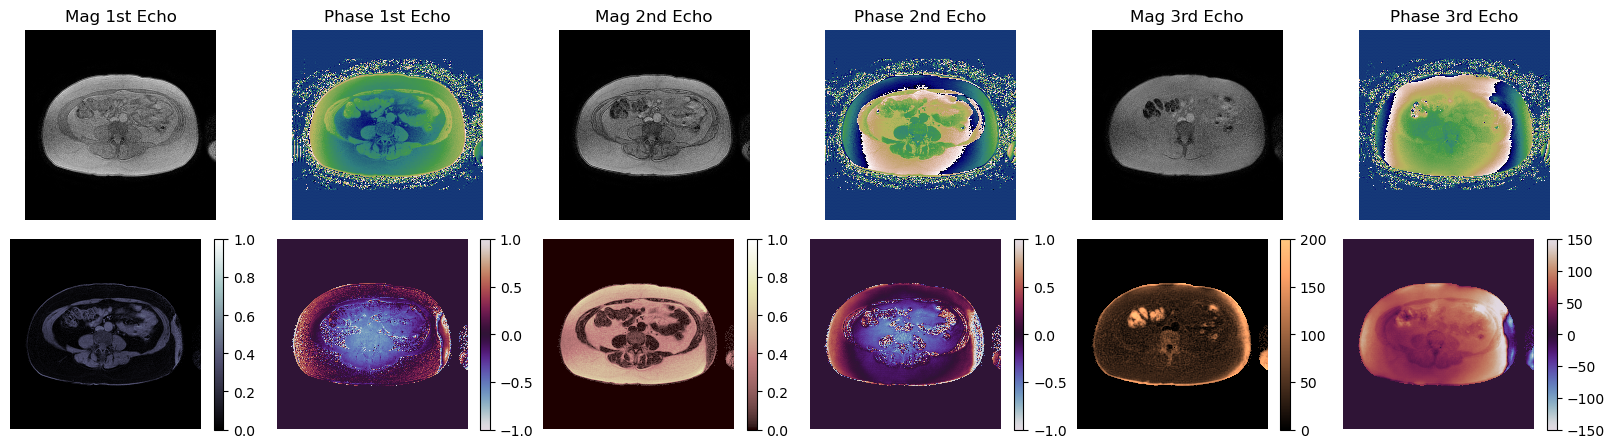

In [21]:
fig, axs = plt.subplots(figsize=(16, 4), nrows=2, ncols=6)

# Acquisitions in the first row
acq_ech1 = axs[0,0].imshow(mag_ech1, cmap='gray',
                      interpolation='none', vmin=0, vmax=1)
axs[0,0].set_title('Mag 1st Echo')
axs[0,0].axis('off')
acq_ech2 = axs[0,1].imshow(pha_ech1/np.pi, cmap='gist_earth',
                      interpolation='none', vmin=-1, vmax=1)
axs[0,1].set_title('Phase 1st Echo')
axs[0,1].axis('off')
acq_ech3 = axs[0,2].imshow(mag_ech2, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,2].set_title('Mag 2nd Echo')
axs[0,2].axis('off')
acq_ech4 = axs[0,3].imshow(pha_ech2/np.pi, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,3].set_title('Phase 2nd Echo')
axs[0,3].axis('off')
acq_ech5 = axs[0,4].imshow(mag_ech3, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,4].set_title('Mag 3rd Echo')
axs[0,4].axis('off')
acq_ech6 = axs[0,5].imshow(pha_ech3/np.pi, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,5].set_title('Phase 3rd Echo')
axs[0,5].axis('off')

# A2B maps in the second row
W_ok =  axs[1,0].imshow(w_m_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=axs[1,0])
axs[1,0].axis('off')

Wp_ok =  axs[1,1].imshow(w_p_aux/np.pi, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Wp_ok, ax=axs[1,1])
axs[1,1].axis('off')

F_ok =  axs[1,2].imshow(f_m_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=axs[1,2])
axs[1,2].axis('off')

Fp_ok =  axs[1,3].imshow(f_p_aux/np.pi, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Fp_ok, ax=axs[1,3])
axs[1,3].axis('off')

r2_ok = axs[1,4].imshow(r2_aux*r2_sc, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[1,4])
axs[1,4].axis('off')

field_ok =  axs[1,5].imshow(field_aux*fm_sc, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=axs[1,5])
axs[1,5].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
fig.set_facecolor("none")
plt.show()

In [ ]:
if A2B_var is not None:
    from matplotlib.colors import LogNorm
    fig, axs = plt.subplots(figsize=(15, 4), nrows=2, ncols=5)

    # Estimated maps
    FF_ok = axs[0,0].imshow(PDFF_aux, cmap='jet',
                            interpolation='none', vmin=0, vmax=1)
    fig.colorbar(FF_ok, ax=axs[0,0])
    axs[0,0].axis('off')
    W_ok =  axs[0,1].imshow(w_m_aux, cmap='bone',
                            interpolation='none', vmin=0, vmax=1)
    fig.colorbar(W_ok, ax=axs[0,1])
    axs[0,1].axis('off')

    F_ok =  axs[0,2].imshow(f_m_aux, cmap='pink',
                            interpolation='none', vmin=0, vmax=1)
    fig.colorbar(F_ok, ax=axs[0,2])
    axs[0,2].axis('off')

    r2_ok = axs[0,3].imshow(r2_aux*r2_sc, cmap='copper',
                            interpolation='none', vmin=0, vmax=r2_sc)
    fig.colorbar(r2_ok, ax=axs[0,3])
    axs[0,3].axis('off')

    field_ok =  axs[0,4].imshow(field_aux*fm_sc, cmap='twilight',
                                interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
    fig.colorbar(field_ok, ax=axs[0,4])
    axs[0,4].axis('off')
    
    WF_uq = axs[1,0].matshow(PDFF_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-2,vmax=1e2))
    fig.colorbar(WF_uq, ax=axs[1,0])
    axs[1,0].axis('off')

    W_uq = axs[1,1].matshow(W_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig.colorbar(W_uq, ax=axs[1,1])
    axs[1,1].axis('off')

    F_uq = axs[1,2].matshow(F_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig.colorbar(F_uq, ax=axs[1,2])
    axs[1,2].axis('off')

    r2s_uq=axs[1,3].matshow(r2s_var, cmap='gnuplot',
                          norm=LogNorm(vmin=1e0,vmax=1e3))
    fig.colorbar(r2s_uq, ax=axs[1,3])
    axs[1,3].axis('off')

    field_uq = axs[1,4].matshow(field_var, cmap='gnuplot2',
                                norm=LogNorm(vmin=1e-5,vmax=1e-2))
    fig.colorbar(field_uq, ax=axs[1,4])
    axs[1,4].axis('off')

In [ ]:
# %matplotlib inline
plt.figure(figsize=(6,4)) # (width,height)
plt.matshow(PDFF_aux*100.0,cmap='jet',vmin=0.0,vmax=100.0, fignum=1)
# plt.matshow(PDFF_var*1e4, cmap='gnuplot2',vmin=0,vmax=1e2, fignum=1)
# plt.matshow(r2_aux*r2_sc, cmap='copper', vmin=0, vmax=r2_sc, fignum=1)
# plt.matshow(r2s_var, cmap='gnuplot', vmin=0,vmax=1e2, fignum=1)
# plt.matshow(w_m_aux, cmap='bone', vmin=0, vmax=1, fignum=1)
# plt.matshow(f_m_aux, cmap='pink', vmin=0, vmax=1, fignum=1)
# plt.matshow(F_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e0))
# plt.matshow(field_aux*fm_sc,cmap='twilight',fignum=1)
# plt.matshow(A2B[0,3,:,:,0],cmap='twilight',vmin=-.5,vmax=.5,fignum=1)
plt.colorbar()
plt.axis('off')

In [ ]:
# A_pha = tf.math.atan2(A[...,1:],A[...,:1]) / np.pi
# A_pha = np.angle(acq[:1,...]) 
# A2B_pha = G_pha(A_pha, training=False)

x = tf.linspace(-.5,.5,A.shape[2])
X, Y = tf.meshgrid(x, x)
B_bp = tf.roll(X,shift=A.shape[2]//2,axis=1) #tf.where(field_aux!=0.0,X,0.0)

# B_diff = B_bp[:,96:192] + B_bp[:,-97:-(192+1):-1] # left half
# B_diff = B_bp[:,-97:-192:-1] # right half

B_bp_tf = tf.expand_dims(B_bp,axis=0)
B_bp_tf = tf.expand_dims(B_bp_tf,axis=-1)
BP_dy, BP_dx = tf.image.image_gradients(B_bp_tf)

plt.figure(figsize=(6,4)) # (width,height)
plt.matshow(np.squeeze(BP_dx))#,cmap='twilight',vmin=-1,vmax=1,fignum=1)
plt.colorbar()
plt.axis('off')

## Export results to a MAT file

In [22]:
if data_sel.value == 'QSM':
    out_id = file_dir.split('/')[-1].split('.')[0]
else:
    out_id = file_dir.split('/')[-2].split('_')[-1]
listdir = file_dir.split('/')[:-1]
listdir.append('res_MP_' + ''.join(model_sel.value.split('-')) + '_' + out_id + '.mat')
outpath = '/'.join(listdir)

outvars = {'F': np.concatenate(F,axis=-1),
           'P': np.concatenate(P,axis=-1),
           'R': np.concatenate(R,axis=-2),
           'R2':np.concatenate(R2,axis=-1),
           'mthd': model_sel.value}

if A2B_var is not None:
    var_outvars = {'F_var': np.concatenate(PDFF_vars, axis=-1),
                   'R_var': np.concatenate(WF_vars, axis=-2),
                   'R2_var': np.concatenate(R2_vars, axis=-1),
                   'P_var': np.concatenate(FM_vars, axis=-1)}
    outvars.update(var_outvars)

sio.savemat(outpath, outvars)

## Optional: Load reference results for comparison

In [ ]:
# out_file_dir = "C:/Users/jpmen/OneDrive - Universidad Católica de Chile/Documents/MRI-Datasets/Anon_JGalgani/004/results_MP_GC/IM_0007_anon_MP_GC.mat"
out_file_dir = "C:/Users/jpmen/OneDrive - Universidad Católica de Chile/Documents/MRI-Datasets/multi-echo/02752/CIB_JAVIER_SILVA/Bipolar-12ech/results_MP_GC_IM_0045/2D_NSA4_12TE_FB_NO_dTE_11_MP_GC.mat"
mat = sio.loadmat(out_file_dir)
B_WF = np.flip(mat['R'].astype('complex64'),axis=-2)
B_WF = B_WF / np.max(np.abs(np.sum(B_WF,axis=-1,keepdims=True)))
B_R2 = np.flip(mat['R2'].astype('float32'),axis=-1)
B_FM = np.flip(mat['P'].astype('float32'),axis=-1)
B_PDFF = np.flip(mat['F'].astype('float32'),axis=-1)

A_msk = np.abs(np.sum(B_WF,axis=-1,keepdims=False))>=5e-2

In [ ]:
B_W = np.expand_dims(mat['fwmc_w'].astype('float32'),axis=-1)
B_F = np.expand_dims(mat['fwmc_f'].astype('float32'),axis=-1)
B_WF = np.concatenate((B_W,B_F),axis=-1)
B_WF = B_WF / np.max(np.abs(np.sum(B_WF,axis=-1,keepdims=True)))
B_R2 = np.flip(mat['fwmc_r2star'].astype('float32'),axis=-1)
B_FM = np.zeros_like(B_R2)
B_PDFF = np.flip(mat['fwmc_ff'].astype('float32'),axis=-1)

if B_W.shape[0] % 16 != 0.0:
    B_W = B_W[:(B_W.shape[0]-B_W.shape[0]%16)]
    B_F = B_F[:(B_F.shape[0]-B_F.shape[0]%16)]
    B_WF= B_WF[:(B_WF.shape[0]-B_WF.shape[0]%16)]
    B_R2= B_R2[:(B_R2.shape[0]-B_R2.shape[0]%16)]
    B_FM = B_FM[:(B_FM.shape[0]-B_FM.shape[0]%16)]
    B_PDFF= B_PDFF[:(B_PDFF.shape[0]-B_PDFF.shape[0]%16)]

A_msk = np.abs(np.sum(B_WF,axis=-1,keepdims=False))>=50e-3

In [ ]:
B_PDFF.shape

In [ ]:
wn_aux = np.abs(B_WF[...,i-1:i,0]) *  A_msk[...,i-1:i] 
fn_aux = np.abs(B_WF[...,i-1:i,1]) *  A_msk[...,i-1:i] 
r2n_aux = np.squeeze(B_R2[...,i-1:i]) * A_msk[...,i-1]
fieldn_aux = np.squeeze(B_FM[...,i-1:i]) * A_msk[...,i-1]
PDFFn_aux = B_PDFF[...,i-1:i]/100.0 * A_msk[...,i-1:i]
PDFF_aux = PDFF_aux * A_msk[...,i-1:i]

fig,axs=plt.subplots(figsize=(12.7, 8), nrows=4, ncols=5)

# Estimated maps in the first row
FF_ok = axs[0,0].imshow(PDFF_aux, cmap='jet',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(FF_ok, ax=axs[0,0])
axs[0,0].axis('off')
W_ok =  axs[0,1].imshow(w_m_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=axs[0,1])
axs[0,1].axis('off')
F_ok =  axs[0,2].imshow(f_m_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=axs[0,2])
axs[0,2].axis('off')
r2_ok = axs[0,3].imshow(r2_aux*r2_sc, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[0,3])
axs[0,3].axis('off')
field_ok =  axs[0,4].imshow(field_aux*fm_sc, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=axs[0,4])
axs[0,4].axis('off')

# Ground-truth maps in the second row
FF_gt = axs[1,0].imshow(PDFFn_aux, cmap='jet',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(FF_gt, ax=axs[1,0])
axs[1,0].axis('off')
W_gt =  axs[1,1].imshow(wn_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_gt, ax=axs[1,1])
axs[1,1].axis('off')
F_gt =  axs[1,2].imshow(fn_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_gt, ax=axs[1,2])
axs[1,2].axis('off')
r2_gt = axs[1,3].imshow(r2n_aux, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_gt, ax=axs[1,3])
axs[1,3].axis('off')
field_gt =  axs[1,4].imshow(fieldn_aux, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_gt, ax=axs[1,4])
axs[1,4].axis('off')

# Error w.r.t. reference in the third row
FF_est =axs[2,0].imshow(np.abs(PDFF_aux-PDFFn_aux), cmap='gray',
                        interpolation='none', vmin=0, vmax=0.2)
fig.colorbar(FF_est, ax=axs[2,0])
axs[2,0].axis('off')
W_est = axs[2,1].imshow(np.abs(w_m_aux-wn_aux), cmap='gray',
                        interpolation='none', vmin=0, vmax=0.2)
fig.colorbar(W_est, ax=axs[2,1])
axs[2,1].axis('off')

F_est = axs[2,2].imshow(np.abs(f_m_aux-fn_aux), cmap='gray',
                        interpolation='none', vmin=0, vmax=0.2)
fig.colorbar(F_est, ax=axs[2,2])
axs[2,2].axis('off')

r2_est= axs[2,3].imshow(np.abs(r2_aux*r2_sc-r2n_aux), cmap='gray',
                        interpolation='none', vmin=0.0, vmax=r2_sc/5)
fig.colorbar(r2_est, ax=axs[2,3])
axs[2,3].axis('off')

field_est = axs[2,4].imshow(np.abs(field_aux*fm_sc-fieldn_aux), cmap='gray',
                            interpolation='none', vmin=0.0, vmax=r2_sc/5)
fig.colorbar(field_est, ax=axs[2,4])
axs[2,4].axis('off')

# Uncertainty maps in the fourth row
WF_uq = axs[3,0].matshow(PDFF_var, cmap='gnuplot2',
                         norm=LogNorm(vmin=1e-2,vmax=1e2))
fig.colorbar(WF_uq, ax=axs[3,0])
axs[3,0].axis('off')
W_uq = axs[3,1].matshow(W_var, cmap='gnuplot2',
                        norm=LogNorm(vmin=1e-2,vmax=1e0))
fig.colorbar(W_uq, ax=axs[3,1])
axs[3,1].axis('off')
F_uq = axs[3,2].matshow(F_var, cmap='gnuplot2',
                        norm=LogNorm(vmin=1e-2,vmax=1e0))
fig.colorbar(F_uq, ax=axs[3,2])
axs[3,2].axis('off')
r2s_uq=axs[3,3].matshow(r2s_var, cmap='gnuplot',
                        norm=LogNorm(vmin=1e0,vmax=1e3))
fig.colorbar(r2s_uq, ax=axs[3,3])
axs[3,3].axis('off')
field_uq = axs[3,4].matshow(field_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-5,vmax=1e-2))
fig.colorbar(field_uq, ax=axs[3,4])
axs[3,4].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.6)

In [ ]:
fig,axs=plt.subplots(figsize=(5, 8), nrows=4, ncols=2)

# Estimated maps in the first row
FF_ok = axs[0,0].imshow(PDFF_aux, cmap='jet',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(FF_ok, ax=axs[0,0])
axs[0,0].axis('off')
r2_ok = axs[0,1].imshow(r2_aux*r2_sc, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[0,1])
axs[0,1].axis('off')

# Ground-truth maps in the second row
FF_gt = axs[1,0].imshow(PDFFn_aux, cmap='jet',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(FF_gt, ax=axs[1,0])
axs[1,0].axis('off')
r2_gt = axs[1,1].imshow(r2n_aux, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_gt, ax=axs[1,1])
axs[1,1].axis('off')

# Error w.r.t. reference in the third row
FF_est =axs[2,0].imshow(np.abs(PDFF_aux-PDFFn_aux), cmap='gray',
                        interpolation='none', vmin=0, vmax=0.2)
fig.colorbar(FF_est, ax=axs[2,0])
axs[2,0].axis('off')
r2_est= axs[2,1].imshow(np.abs(r2_aux*r2_sc-r2n_aux), cmap='gray',
                        interpolation='none', vmin=0.0, vmax=r2_sc/5)
fig.colorbar(r2_est, ax=axs[2,1])
axs[2,1].axis('off')

# Uncertainty maps in the fourth row
WF_uq = axs[3,0].matshow(PDFF_var, cmap='gnuplot2',
                         norm=LogNorm(vmin=1e-2,vmax=1e2))
fig.colorbar(WF_uq, ax=axs[3,0])
axs[3,0].axis('off')
r2s_uq=axs[3,1].matshow(r2s_var, cmap='gnuplot',
                        norm=LogNorm(vmin=1e0,vmax=1e3))
fig.colorbar(r2s_uq, ax=axs[3,1])
axs[3,1].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.6)

In [ ]:
plt.figure(figsize=(6,4)) # (width,height)
# plt.matshow(PDFFn_aux*100.0,cmap='jet',vmin=0.0,vmax=100.0, fignum=1)
plt.matshow(np.abs(PDFF_aux-PDFFn_aux)*100.0, cmap='gray', vmin=0, vmax=20, fignum=1)
plt.colorbar()
plt.axis('off')
plt.show()